# ActivationsHistogram documentation and usage samples

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #for HiDpi display

To use the colorful dimension's `ActivationsHistogram` you need only to import it from `colorfuldim.py` package

In [2]:
from colorfuldim import ActivationsHistogram

Import other fastai code

In [3]:
from fastai.vision import *

# Print current version
from fastai.version import __version__
print('fastai version: ', __version__)

fastai version:  1.0.53.dev0


## The Twin Peaks (of training)

![twin peaks chart idea](../../doc/img/twin_peaks_chart_idea.png)

**TL;DR**: <p>
Seeing the "Twin Peaks" on activations histogram of the last layer is a good sign for a classifier: usually the more the peaks are separated (*level of understanding*) the better is the model.
For a classifier, The positive peak means "YES" and the negative peak means "NO" and they corresponds respectively to the average activation values for presence or absence of a given class. The height of the peaks depends on the relative number of samples, and usually in a classifier the "YES" peak is smaller or equals than the "NO" peak (ie: on 4 class classifier with single label, if samples are equally distributed then NO peak is 3 time higher than the YES one).
    
Eventually the twin peaks chart act as a kind of meaningful "fingerprint" for your distribution, and comparing your train-validation-test peaks gives you a good intuition about the difference of the distributions.

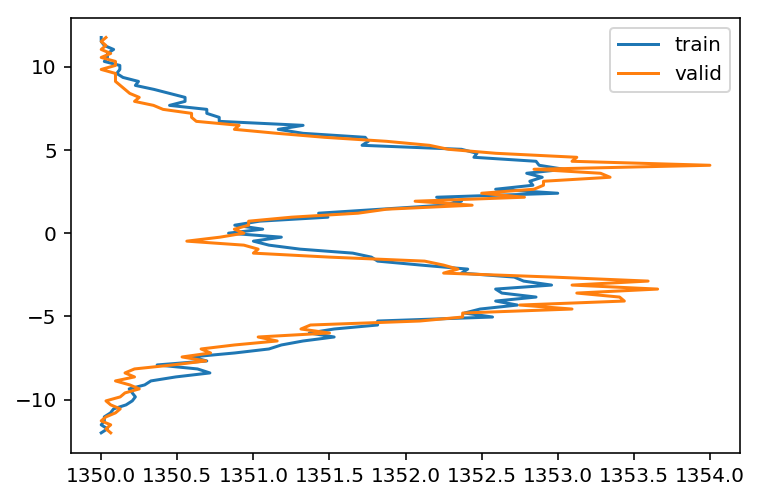

In [4]:
bs = 128
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = cnn_learner(data, models.resnet18, callback_fns=partial(ActivationsHistogram,hMin=-12,hMax=12), metrics=[accuracy])
learn.fit_one_cycle(8,max_lr=slice(1e-3))

**LiveChart**: As you can see the "live chart" shows you on each epoch what is the distribution of activatios in the last layer both for train and validation set.
This chart is useful to point out a number of different properties of your model and dataset such as:
* Distribution "shape" of train and validation set: if the're similar the two curves are very close.
* **The Twin Peaks**: Classifiers: the average value of "YES" (upper Y peak) and "NO" (lower Y peak). Remember that usually in a classifier the activations of last layer are the "predictions" before loss function.
* **IMPORTANT**: you can notice that the **accuracy increases with the the separation of "peaks"**.

**NOTE**: by default to reduce the computation, only the last layer activation is computed.

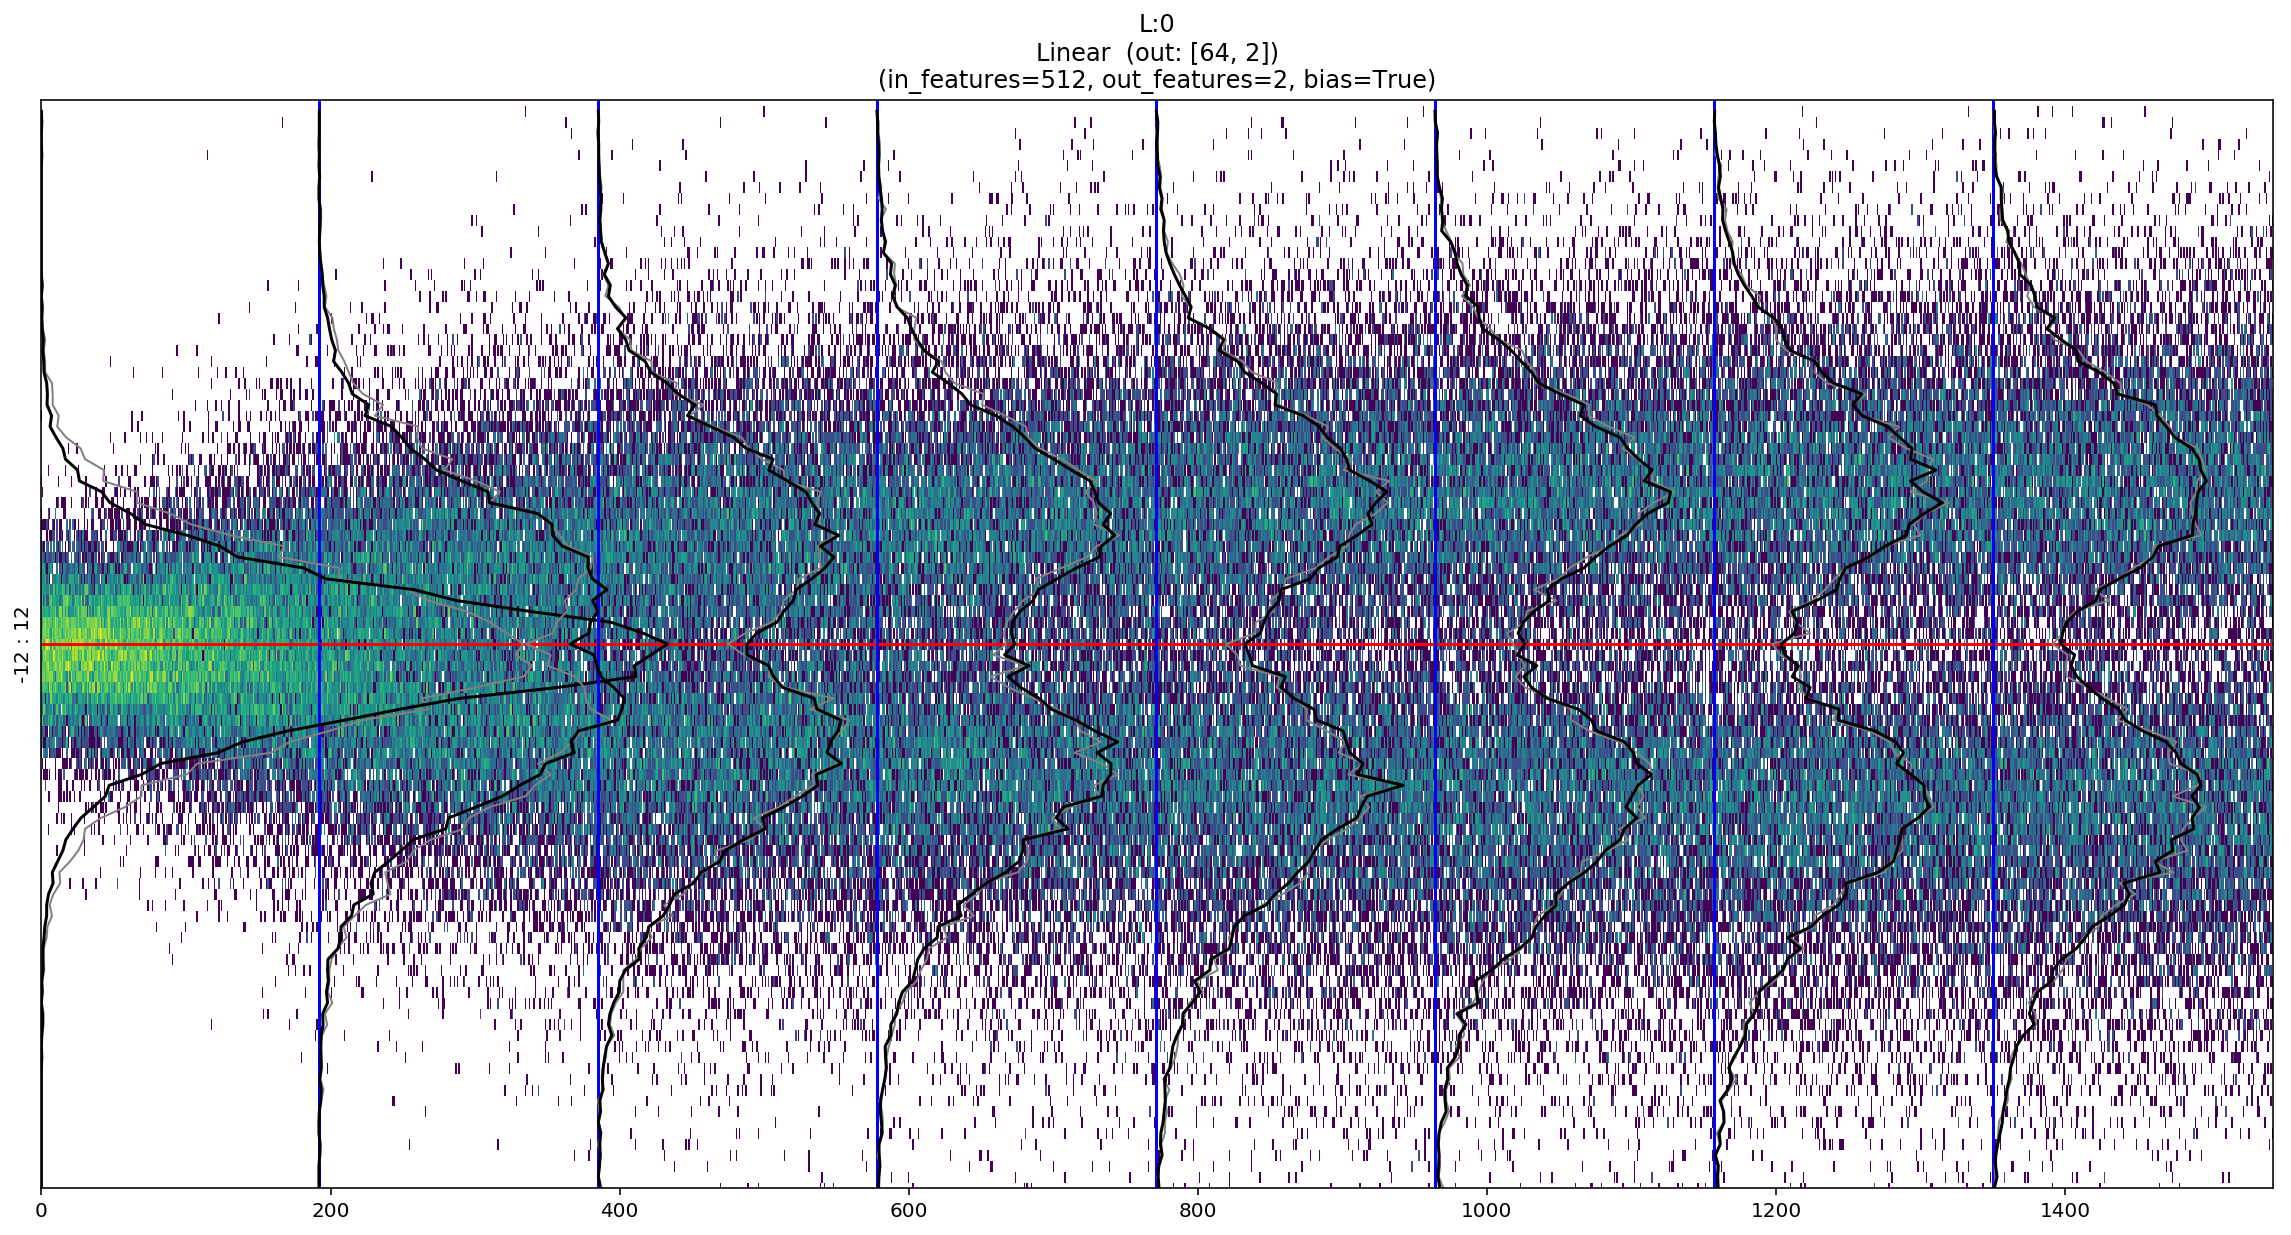

In [5]:
learn.activations_histogram.plotActsHist(hScale=50, showLayerInfo=True)

### What happens behind the scene

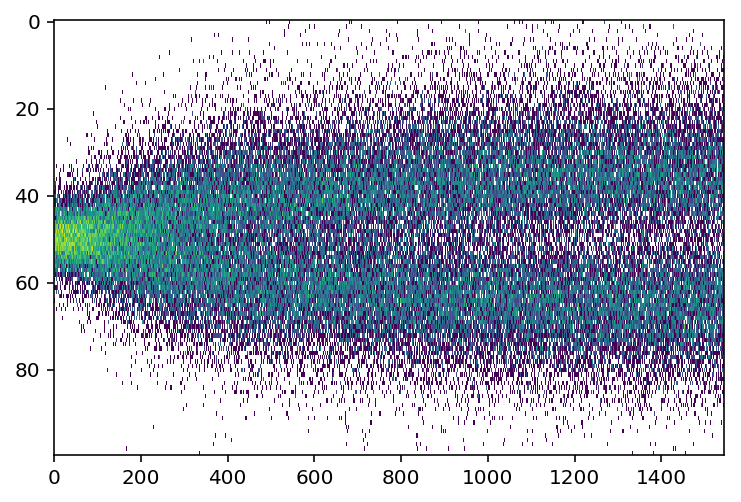

In [6]:
#The colorful dimension chart 
T=learn.activations_histogram.stats_hist[-1,:,:,0] # Take the firs histogram list of last layer
T=T.transpose(1,0)
plt.imshow(T.log(),aspect='auto'); # Log to "enhance the details"

**ASSUMPTION**: the average of histograms has *similar distribution* to the histogram of of the average of data.

NO: -3.651428571428564
YES: 3.4800000000000137


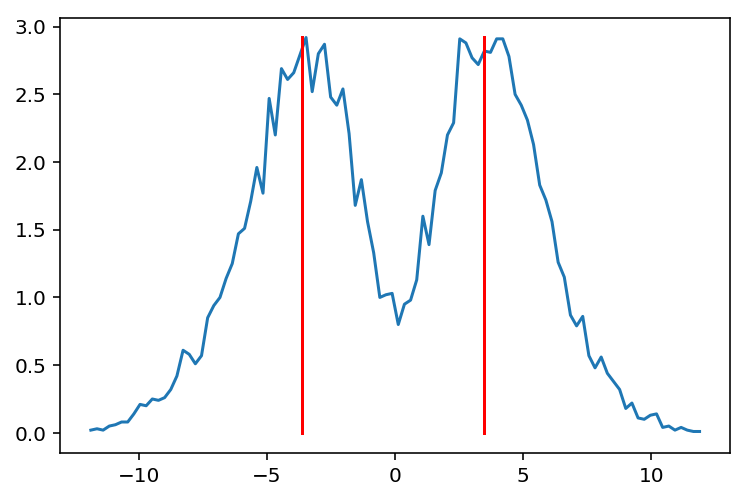

In [7]:
#Plot the average along batches (x) of the activation histogram
TP=T[:,-100:] # Take the last 100 values
TP=TP.mean(1)

#Compute figure
hMin = learn.activations_histogram.hMin
hMax = learn.activations_histogram.hMax
step = (hMax-hMin)/learn.activations_histogram.nBins
XX = np.arange(hMin,hMax,step) + (step/2)
YY = np.array(TP)

yMax = YY.max()

aboveMean = YY>(YY.mean()*2)
aboveMean = aboveMean.astype('float')
midId=len(YY)//2

#
nnzeroL = aboveMean[:midId].nonzero()
aboveMean[nnzeroL] = 0
nnzeroR = aboveMean.nonzero()
value_no = XX[nnzeroL].mean()
value_yes = XX[nnzeroR].mean()

plt.plot(XX,YY);
plt.plot([value_no,value_no],[0,yMax],color='r')
plt.plot([value_yes,value_yes],[0,yMax],color='r')
print(f'NO: {value_no}')
print(f'YES: {value_yes}')

The "two peaks" corrisponds to the average values for activations in the last layer, before loss function (CrossEntropy in this case).

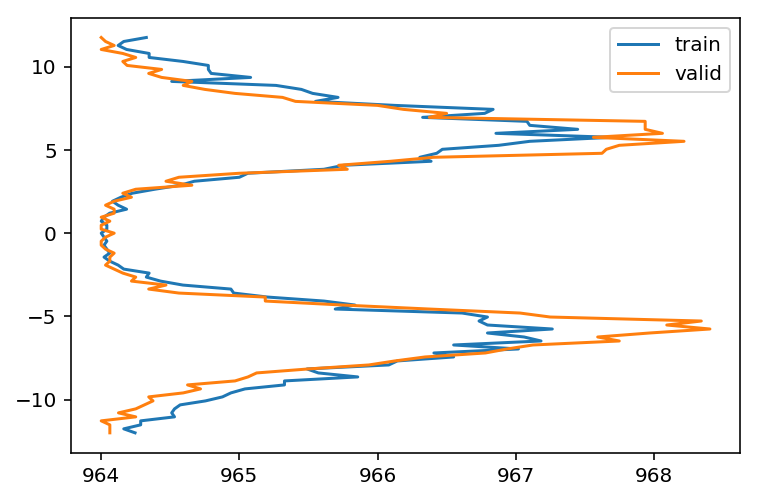

In [8]:
learn.unfreeze()
learn.fit_one_cycle(6,max_lr=slice(1e-3))

As you can see unfreezing increase the accuracy and the separation of peaks (understanding).

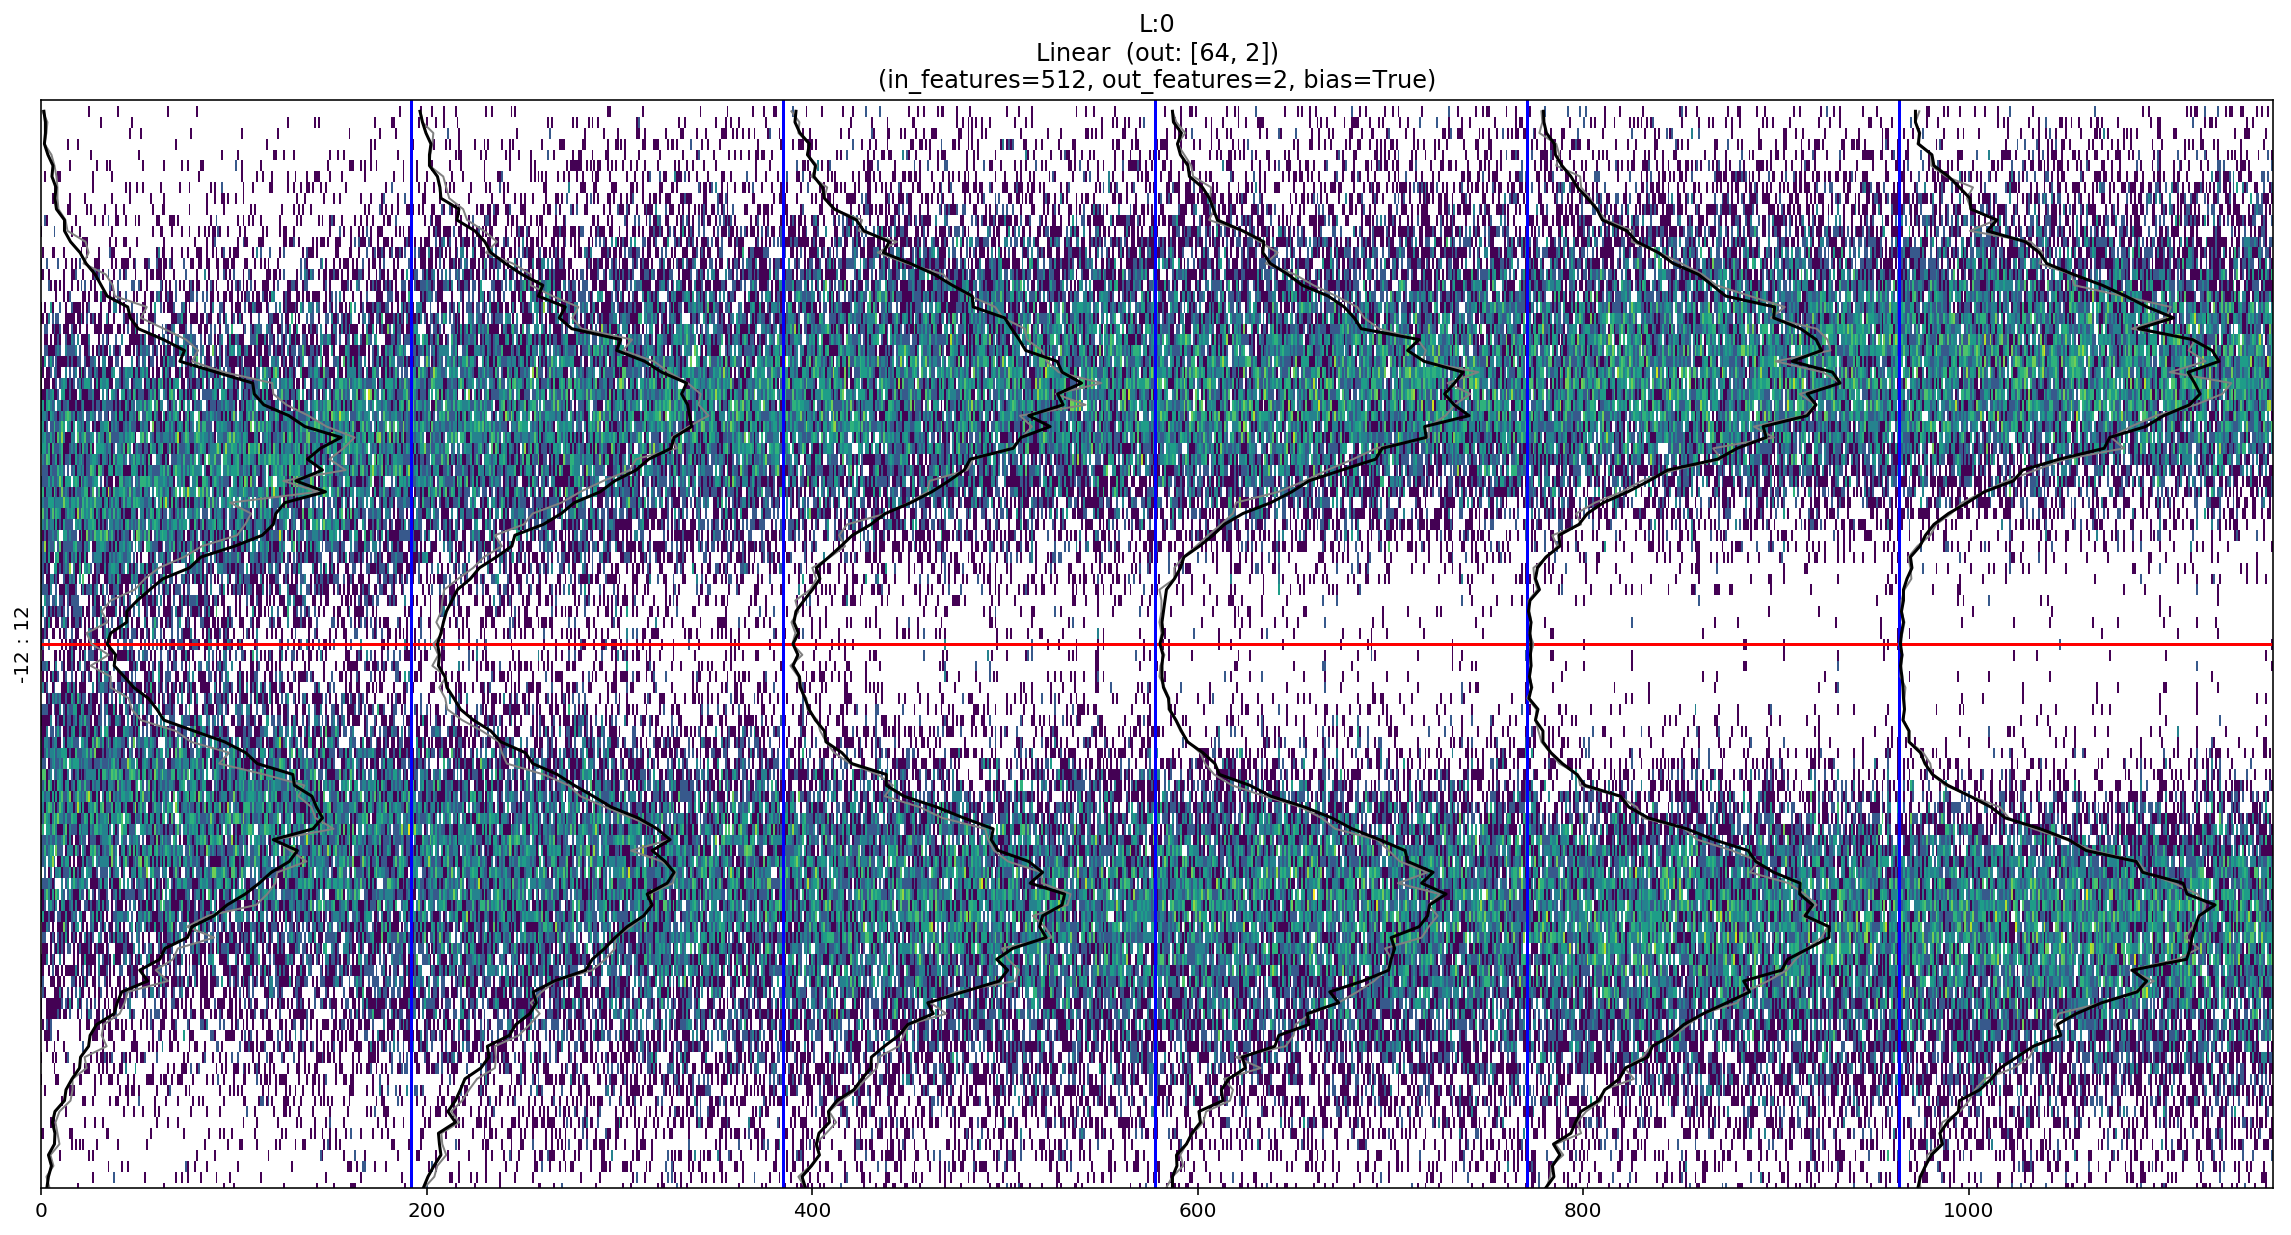

In [9]:
learn.activations_histogram.plotActsHist(hScale=50, showLayerInfo=True)

## Customize the ActivationsHistogram

```python
ActivationsHistogram(learn: fastai.basic_train.Learner, 
                     do_remove: bool = True, 
                     hMin=-1, hMax=1, nBins=100, 
                     useClasses=False, 
                     liveChart=True, 
                     modulesId=-1)
```

+ **`learn`** : Learner to attach to.
+ **`do_remove`** : Default fastai Callback parameter. 
+ **`hMin=-1, hMax=1, nBins=100`** : Histogram parameters that controls range (hMin,HMax) and density (nBins).
+ **`useClasses=False`** : If true compute one separate histograms for each target class. 
+ **`liveChart=True`** : If true shows the average of last computed layer activation during training.
+ **`modulesId=-1`** : List of layers to compute Actiovations Histogram. None means all layers.

**NOTE**: the Histogram Parameters should be specified at initialization time (not at plot time) because the histogram is computed during training.

## Customize plotActsHist parameters

```python
plotActsHist(cols=3, figsize=(20, 10), toDisplay=None, hScale=0.05, 
             showAverage=True, showLayerType=False, aspectAuto=True)
```

+ **`cols=3 `** : Number of columns to display (rows come automatically)
+ **`figsize=(20,10)`** : figure size
+ **`toDisplay=None `** : Array of computed layer to display. None means all. `[0,-1]` means first and last.
+ **`hScale=0.05`** : Horizontal scale of average by epoch histogram.
+ **`showAverage=True`** : Shows average histogram.
+ **`showLayerInfo=False`** : Shows layer details
+ **`aspectAuto=True`** : Plot aspect ratio
+ **`showImage=True`** : If true shows the colorful dimension chart on background

## Examples

Define a support funciton to train a network according to the specific activations histogram requred.

In [10]:
def train_with_hist(actshist, doDefaultPlot=True, hScale=200):
    bs = 128
    path = untar_data(URLs.MNIST_SAMPLE)
    data = ImageDataBunch.from_folder(path)
    learn = cnn_learner(data, models.resnet18, callback_fns=actshist, metrics=[accuracy])
    learn.fit_one_cycle(4,max_lr=slice(1e-3,1e-2))
    if doDefaultPlot: learn.activations_histogram.plotActsHist(hScale=hScale, figsize=(10,4))
    return learn

### Change Histogram parametes (hMin, hMax, nBins)

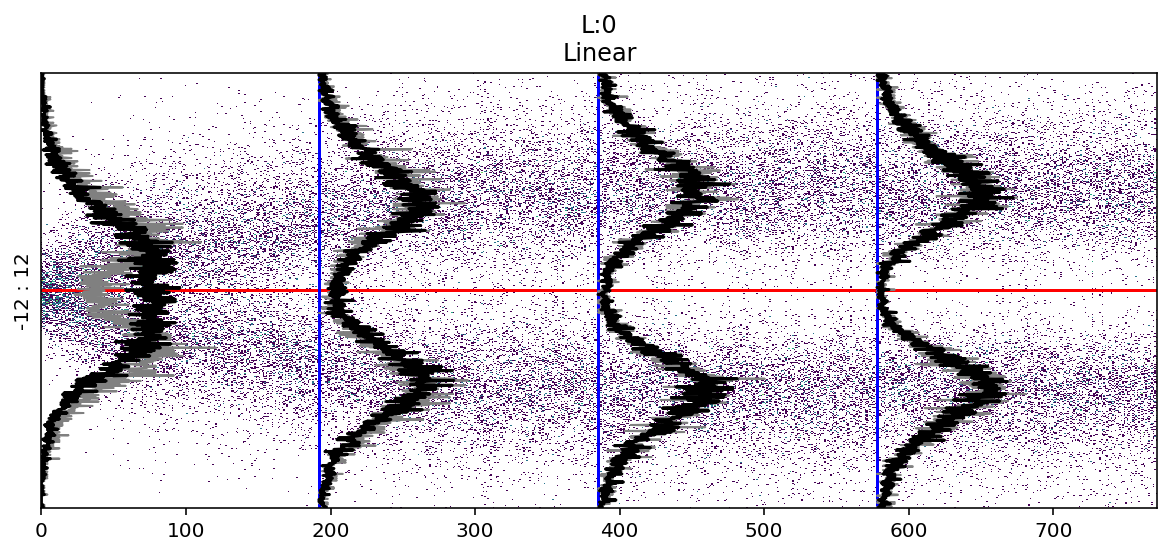

In [11]:
ah_high_resolution = partial(ActivationsHistogram, hMin=-12, hMax=12, nBins=800, liveChart=False)
learn = train_with_hist(ah_high_resolution)

**NOTE**: black curve is the average on the whole epoch, gray curve is the average of the last 25% of the epoch, so if grey and black line differ it means that things are changing during the epoch, as you can see in the first epoch above.

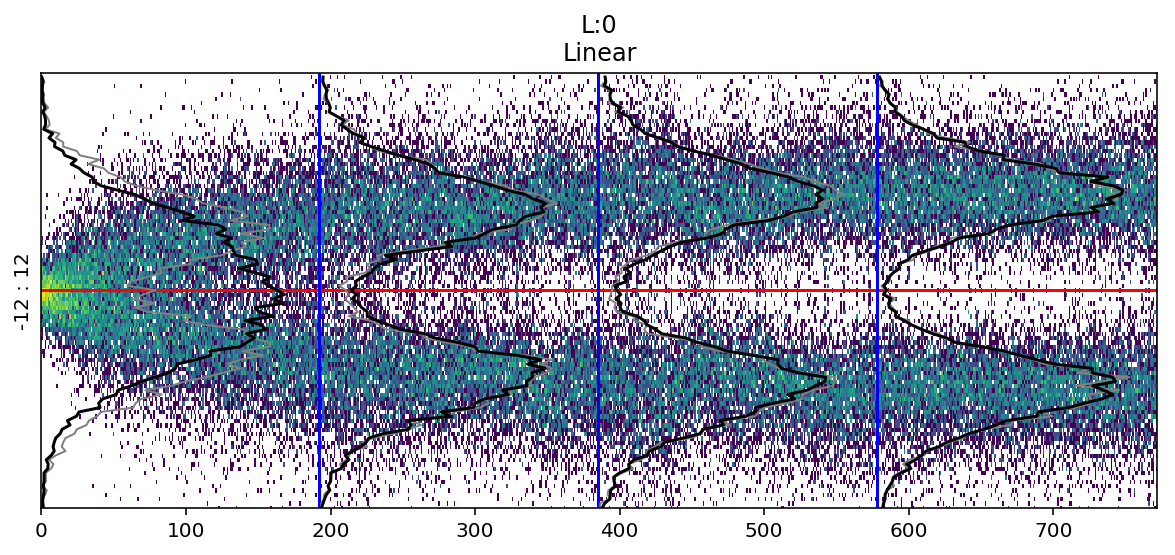

In [12]:
ah_low_resolution = partial(ActivationsHistogram, hMin=-12, hMax=12, nBins=100, liveChart=False)
learn = train_with_hist(ah_low_resolution, hScale=50)

As you can see, higher resolution on the last layer shows that activations spreads on a broader spectrum, while the lower resolution reduces the fluctuations.

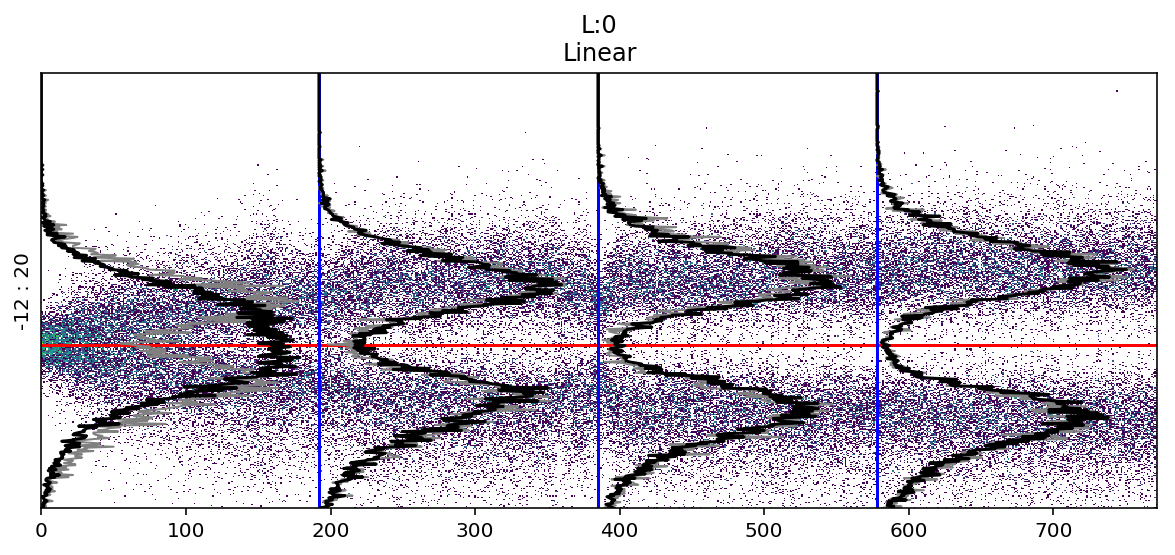

In [13]:
ah_inbalance_range = partial(ActivationsHistogram, hMin=-12, hMax=20, nBins=400, liveChart=False)
learn = train_with_hist(ah_inbalance_range, hScale=150)

Note that the plot is not symmetrical around '0' (red line)

### Compute activations for all layers (modulesId=None) and hide epochs lines (showEpochs)

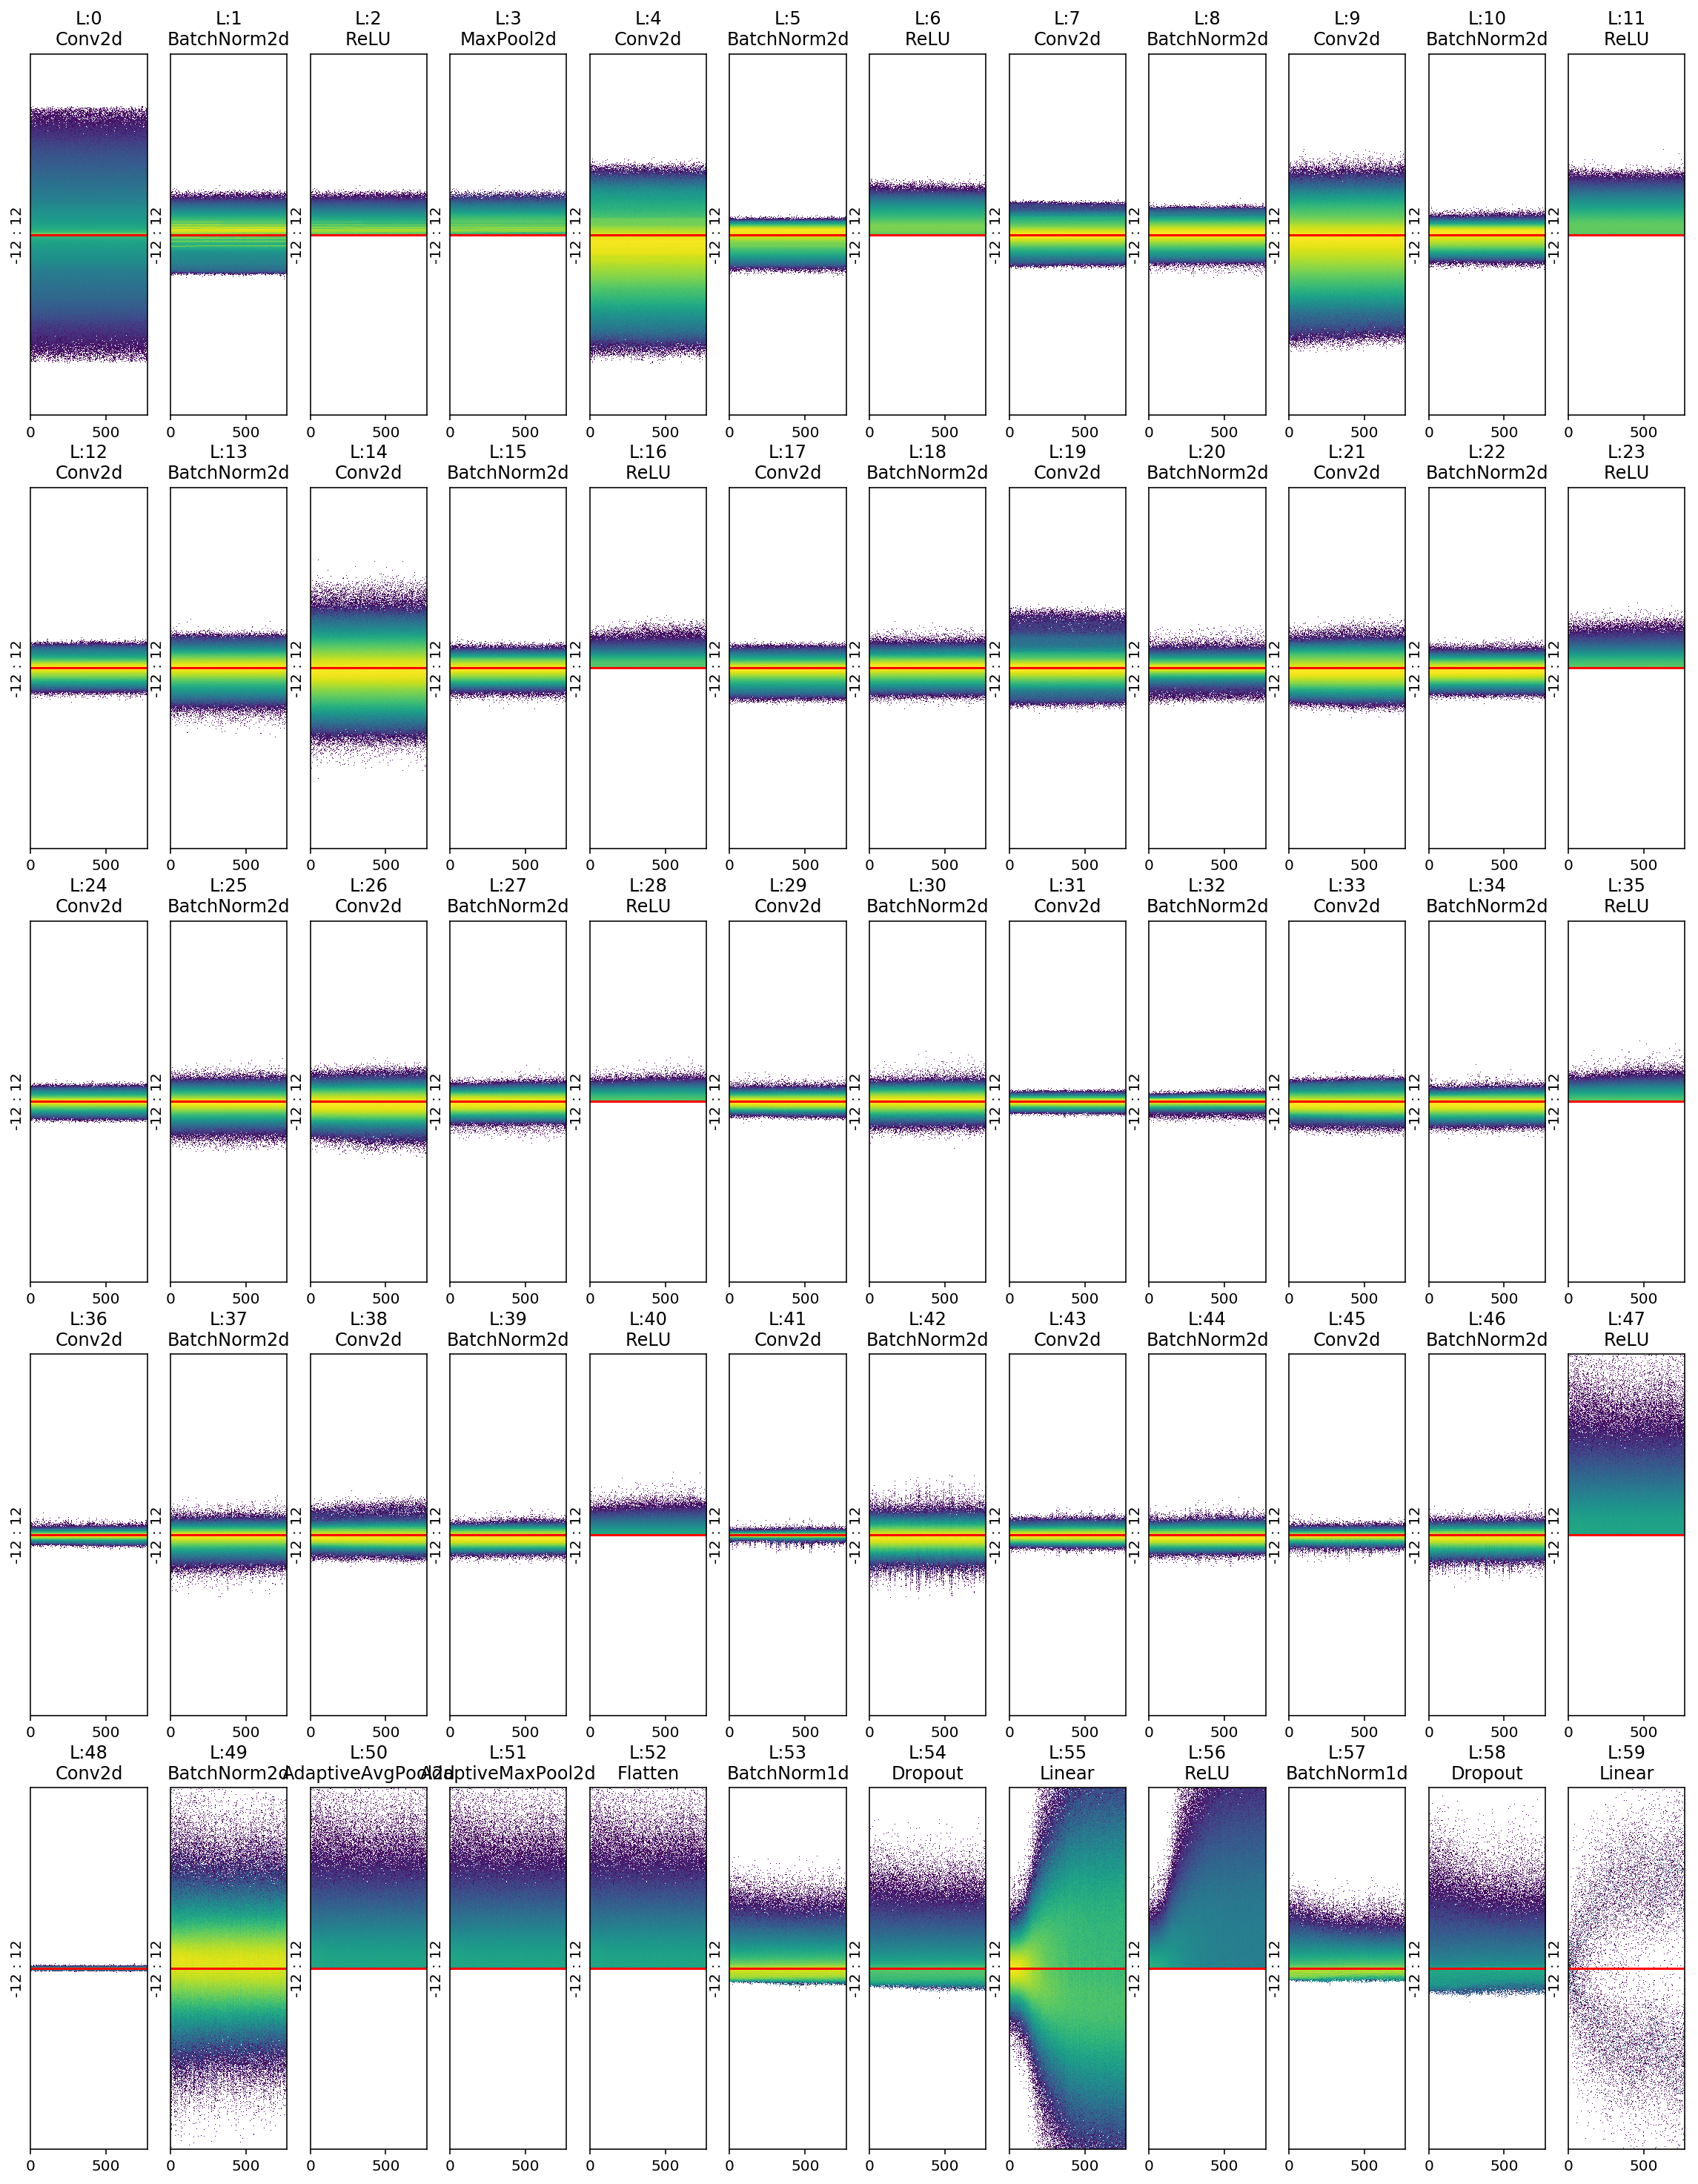

In [14]:
ah_all_layers = partial(ActivationsHistogram, hMin=-12, hMax=12, nBins=800, modulesId=None, liveChart=False)
learn = train_with_hist(ah_all_layers, doDefaultPlot=False)
learn.activations_histogram.plotActsHist(cols=12, figsize=(20,26), showEpochs=False)

**IMPORTANT**: computing all layers activations slows down the training process.

### Select what layers to plot (toDisplay) and display layer info (showLayerInfo)

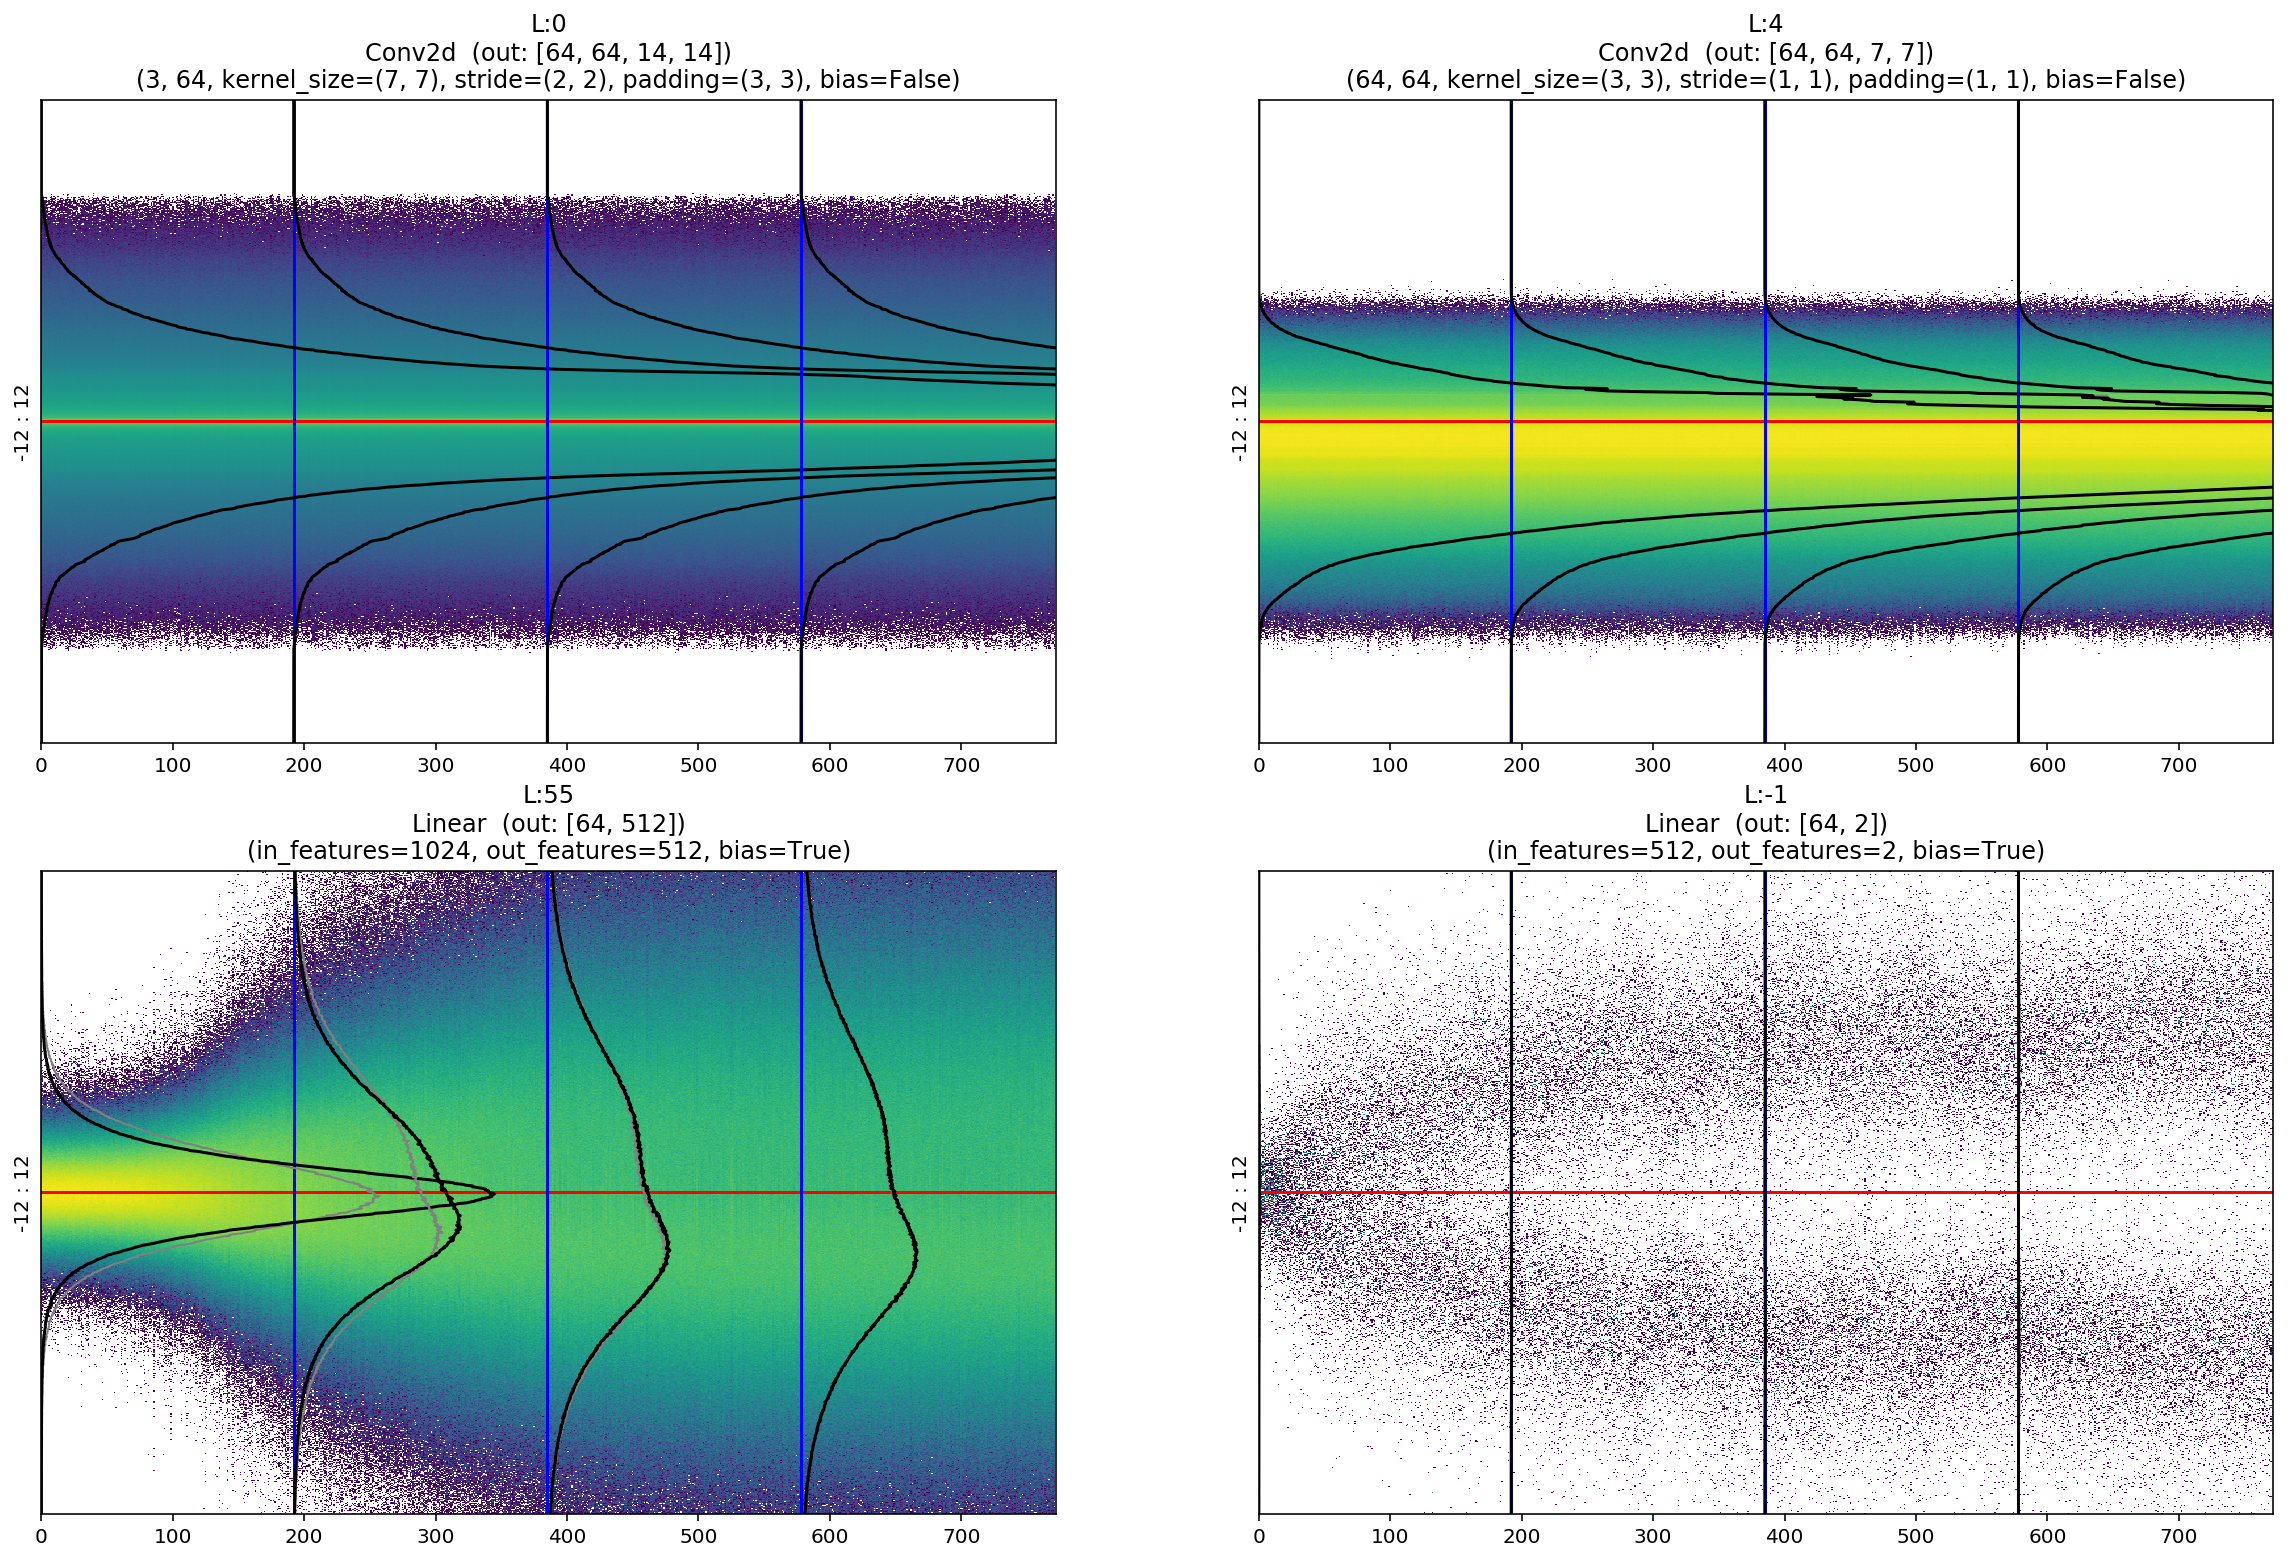

In [16]:
learn.activations_histogram.plotActsHist(cols=2, figsize=(20,13), showEpochs=True, toDisplay=[0,4,55,-1], hScale=1, showLayerInfo=True)

**NOTE:** the linear layer L55 seems to behave like last linear layer, spreading activations in a similar way; note, especially in the last epoch, that even on layer L55 the two "peaks" are forming from normal distribution. 

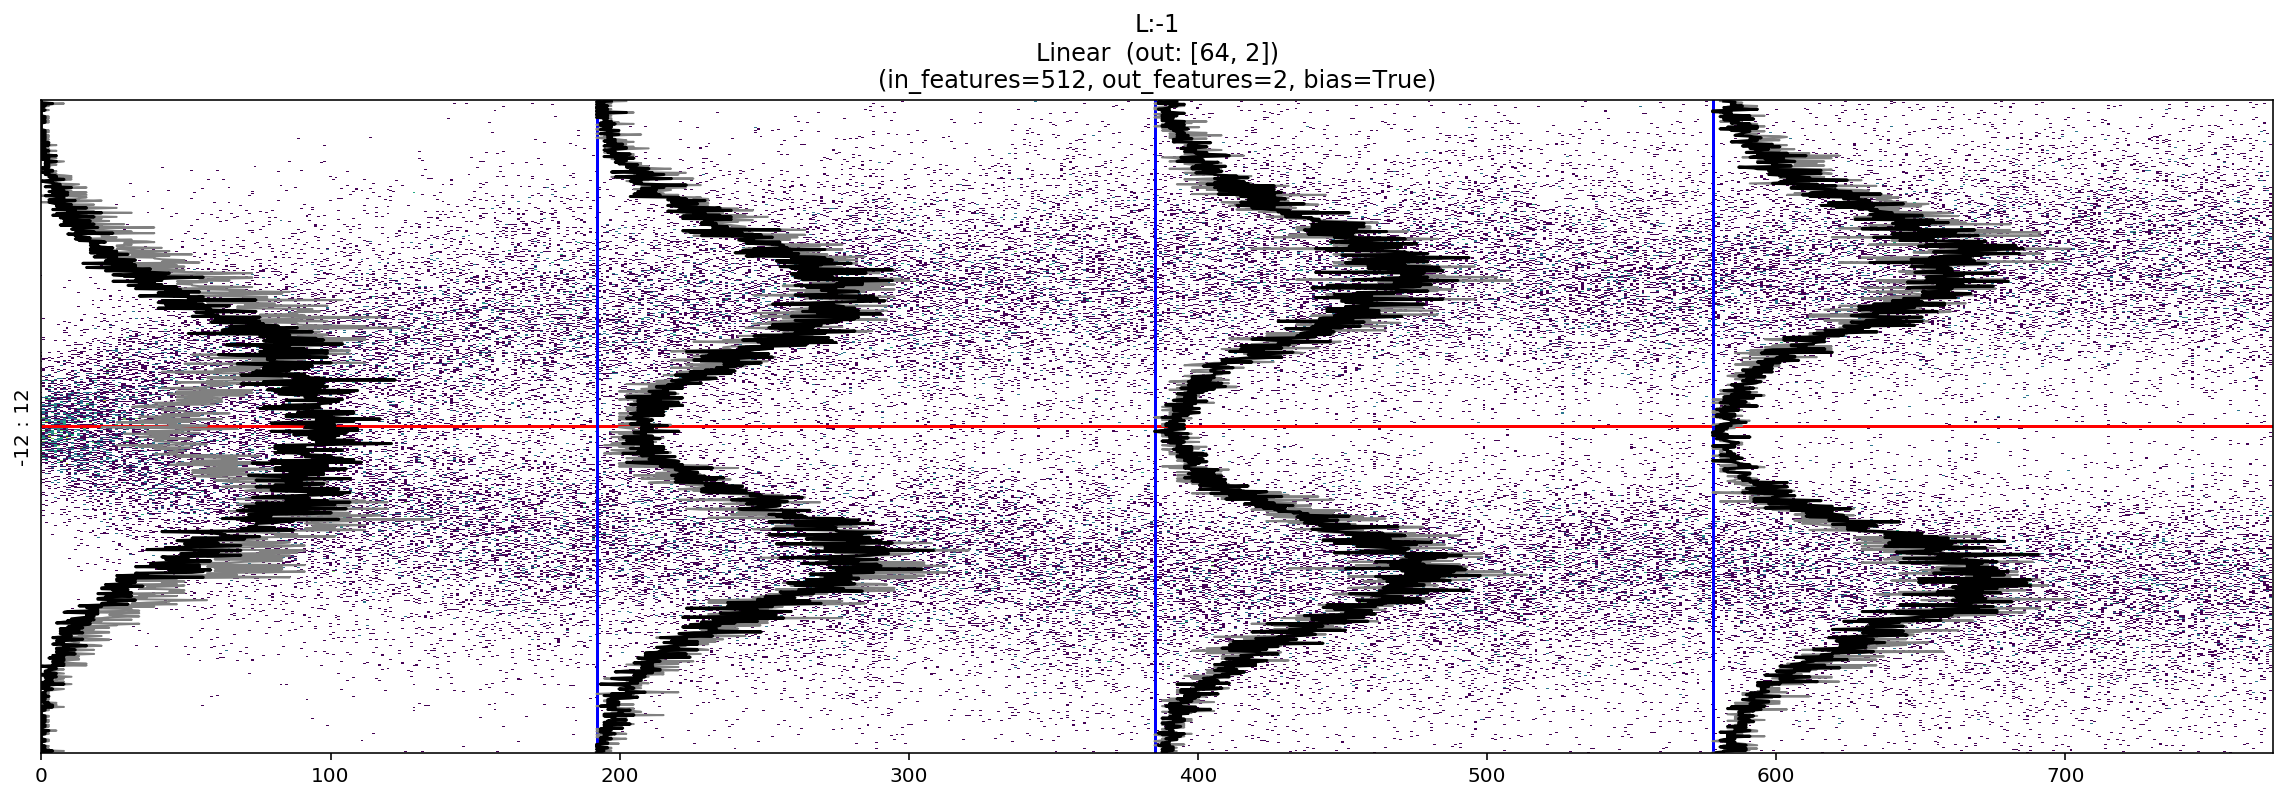

In [15]:
learn.activations_histogram.plotActsHist(cols=4, figsize=(20,6), showEpochs=True, toDisplay=[-1], hScale=250, showLayerInfo=True)

### Hide backgroud image (showImage=False)

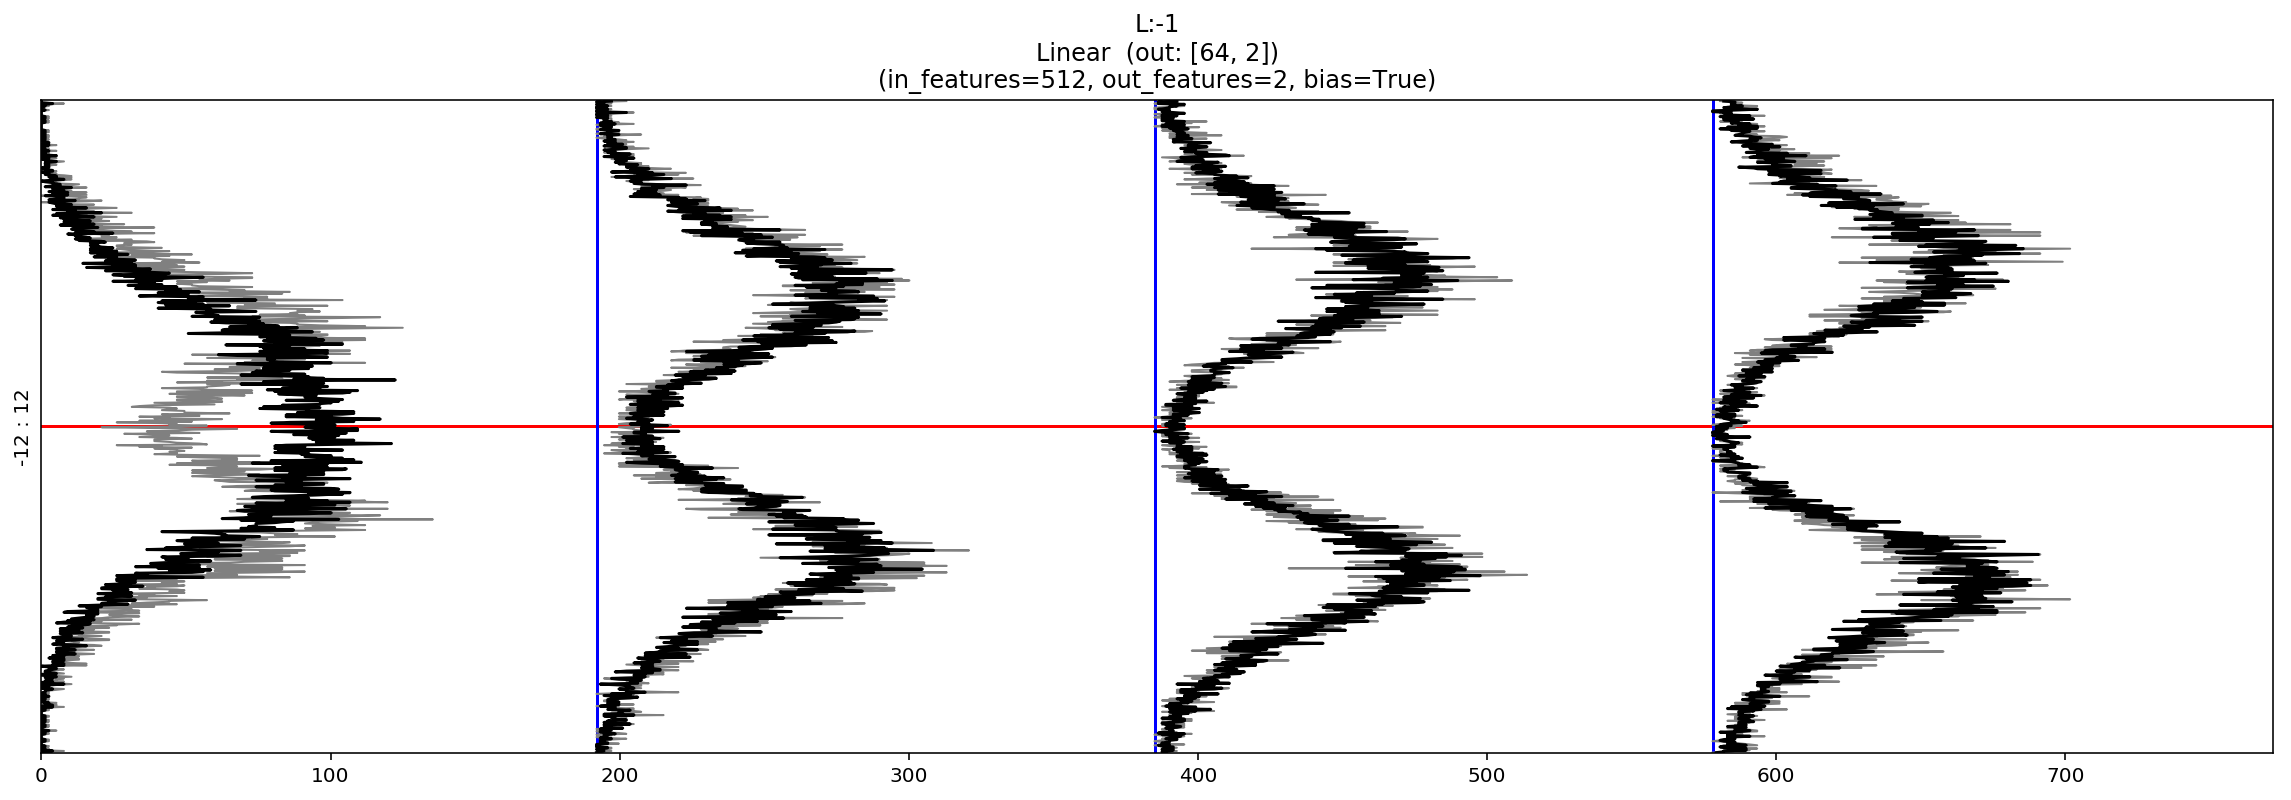

In [17]:
learn.activations_histogram.plotActsHist(cols=4, figsize=(20,6), showEpochs=True, toDisplay=[-1], hScale=250, showLayerInfo=True, showImage=False)

### One Histogram for each class (useClasses=True)

Len befor: 60000
Classes: 10 => ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


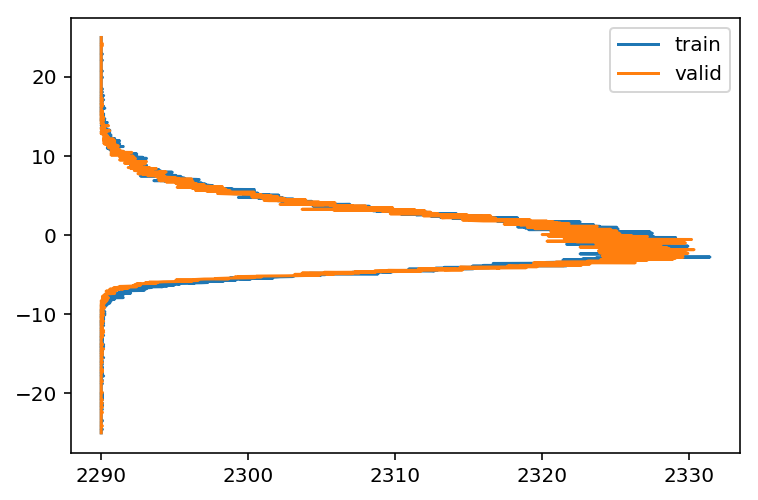

In [17]:
ah_multiple_classes = partial(ActivationsHistogram,hMin=-25,hMax=25,nBins=1600,modulesId=-1,useClasses=True)

bs = 1024
path = untar_data(URLs.CIFAR)
items = ImageList.from_folder(path)
print(f'Len befor: {len(items)}')
data = (items.split_by_rand_pct(.2,seed=123)
        .label_from_folder()
        .databunch(bs=bs)
       )
print(f'Classes: {data.c} => {data.classes}')

learn = cnn_learner(data, models.resnet50, 
                    callback_fns=ah_multiple_classes,
                    metrics=accuracy)
learn.fit_one_cycle(6,max_lr=slice(1e-3,1e-2))

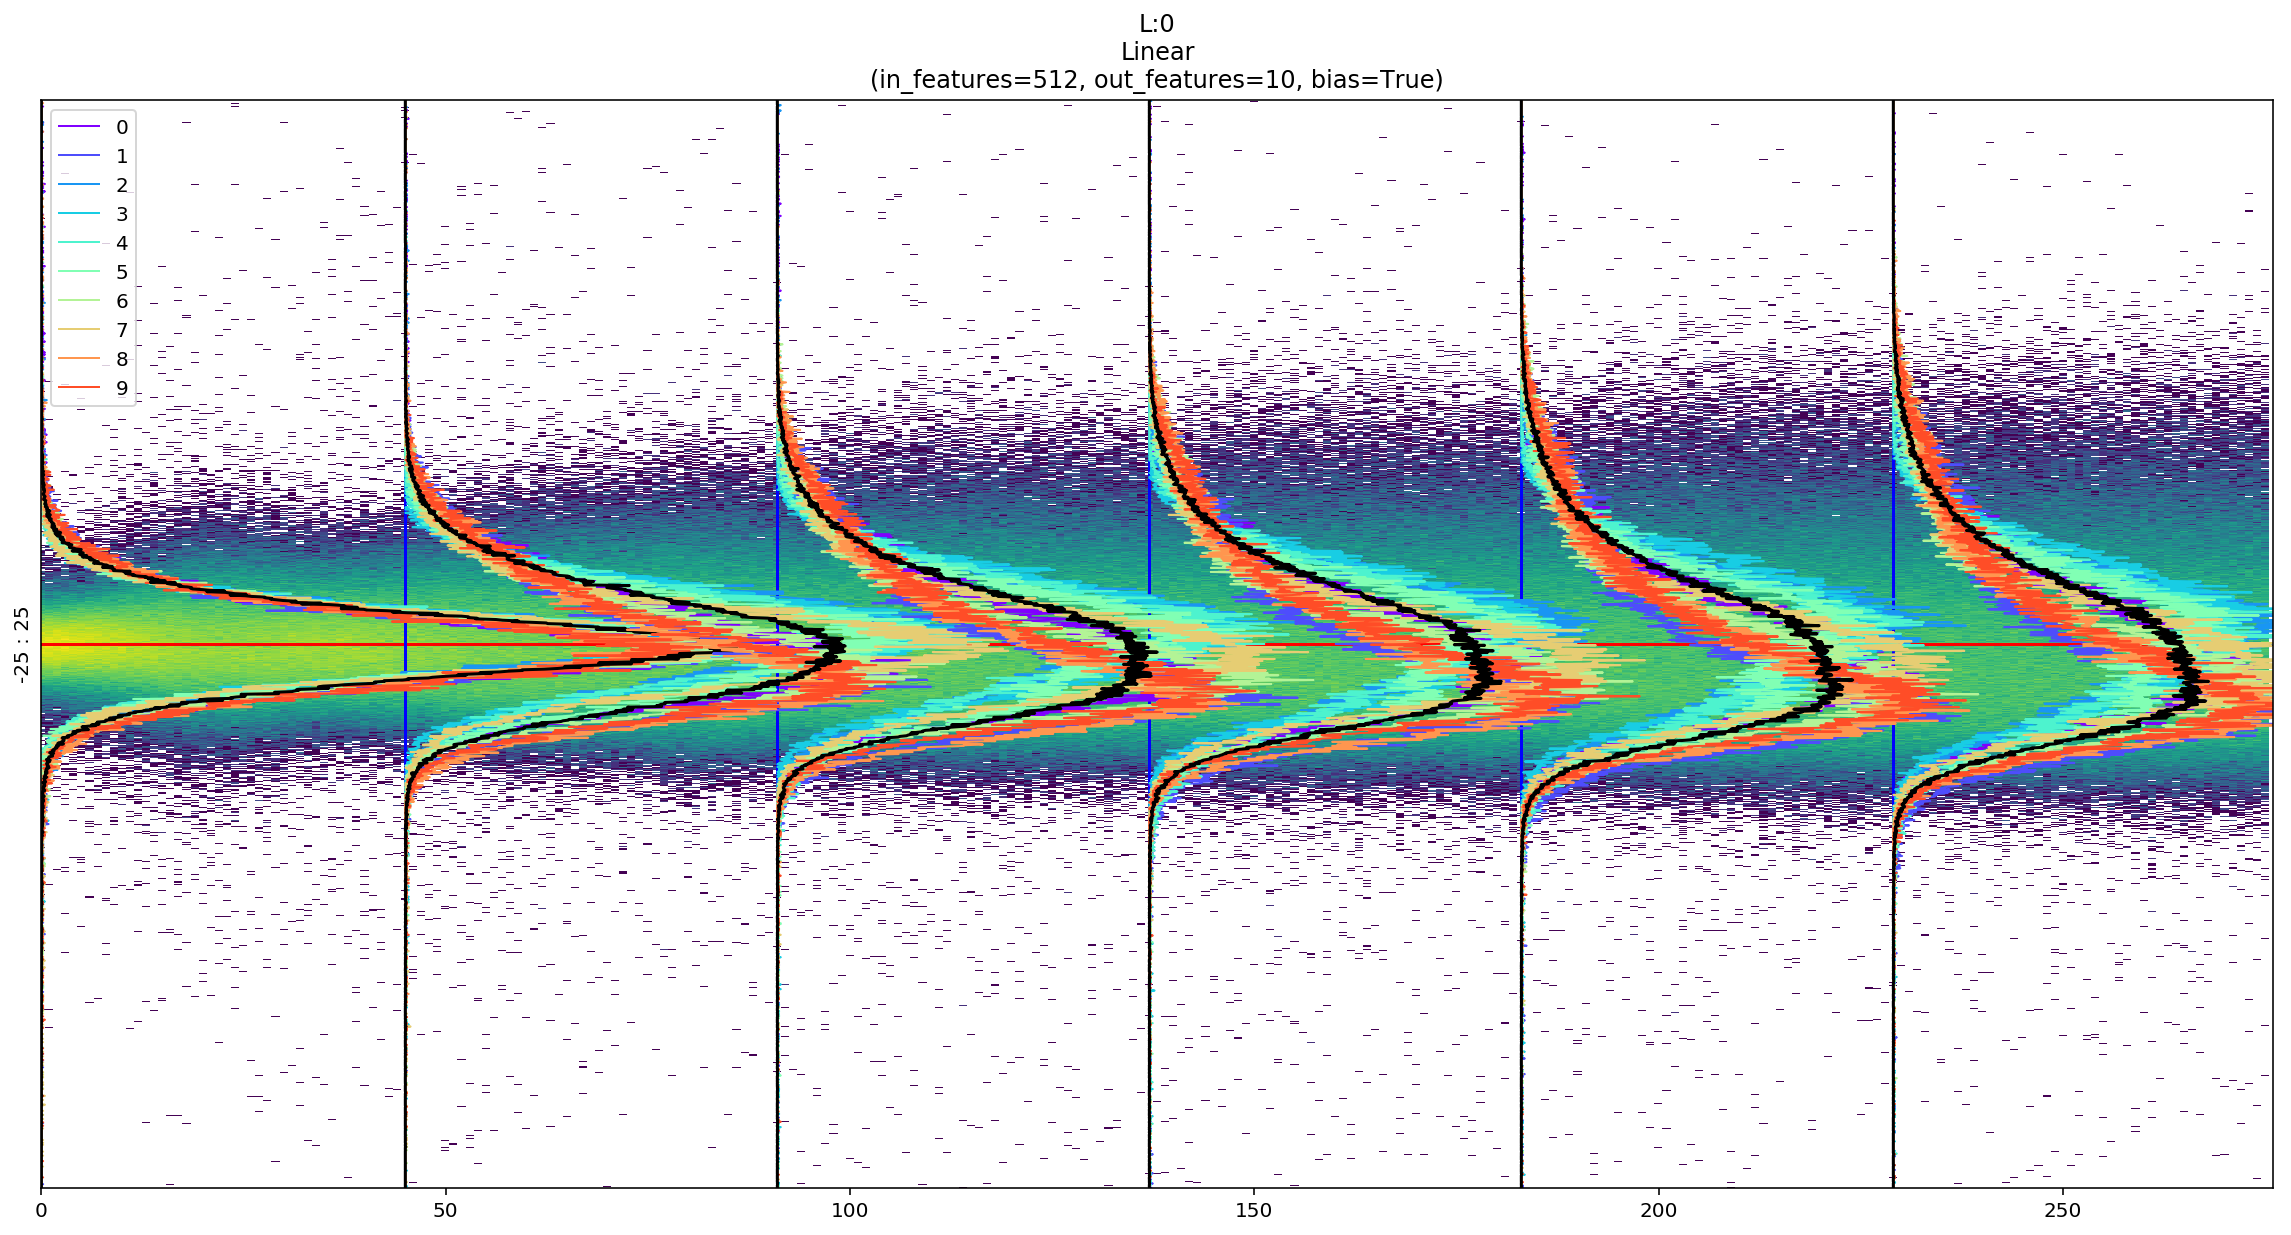

In [18]:
learn.activations_histogram.plotActsHist(cols=1, figsize=(20,10), showEpochs=True, hScale=10, showLayerInfo=True)

In [19]:
learn.unfreeze()

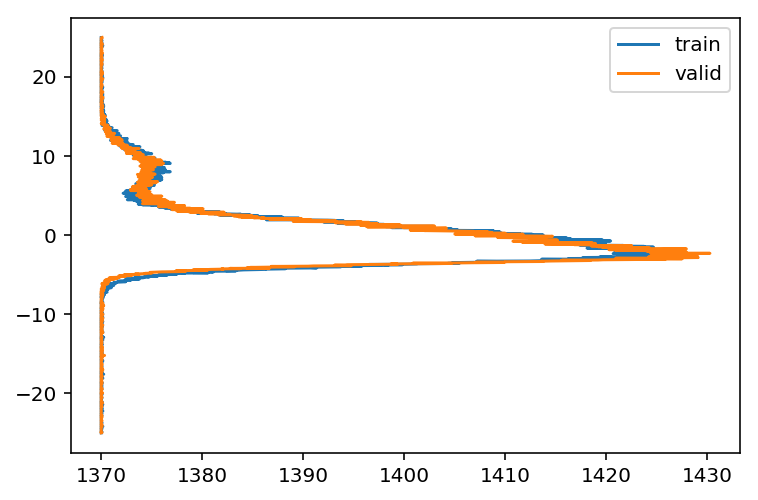

In [20]:
learn.fit_one_cycle(4,max_lr=slice(1e-3,1e-2))

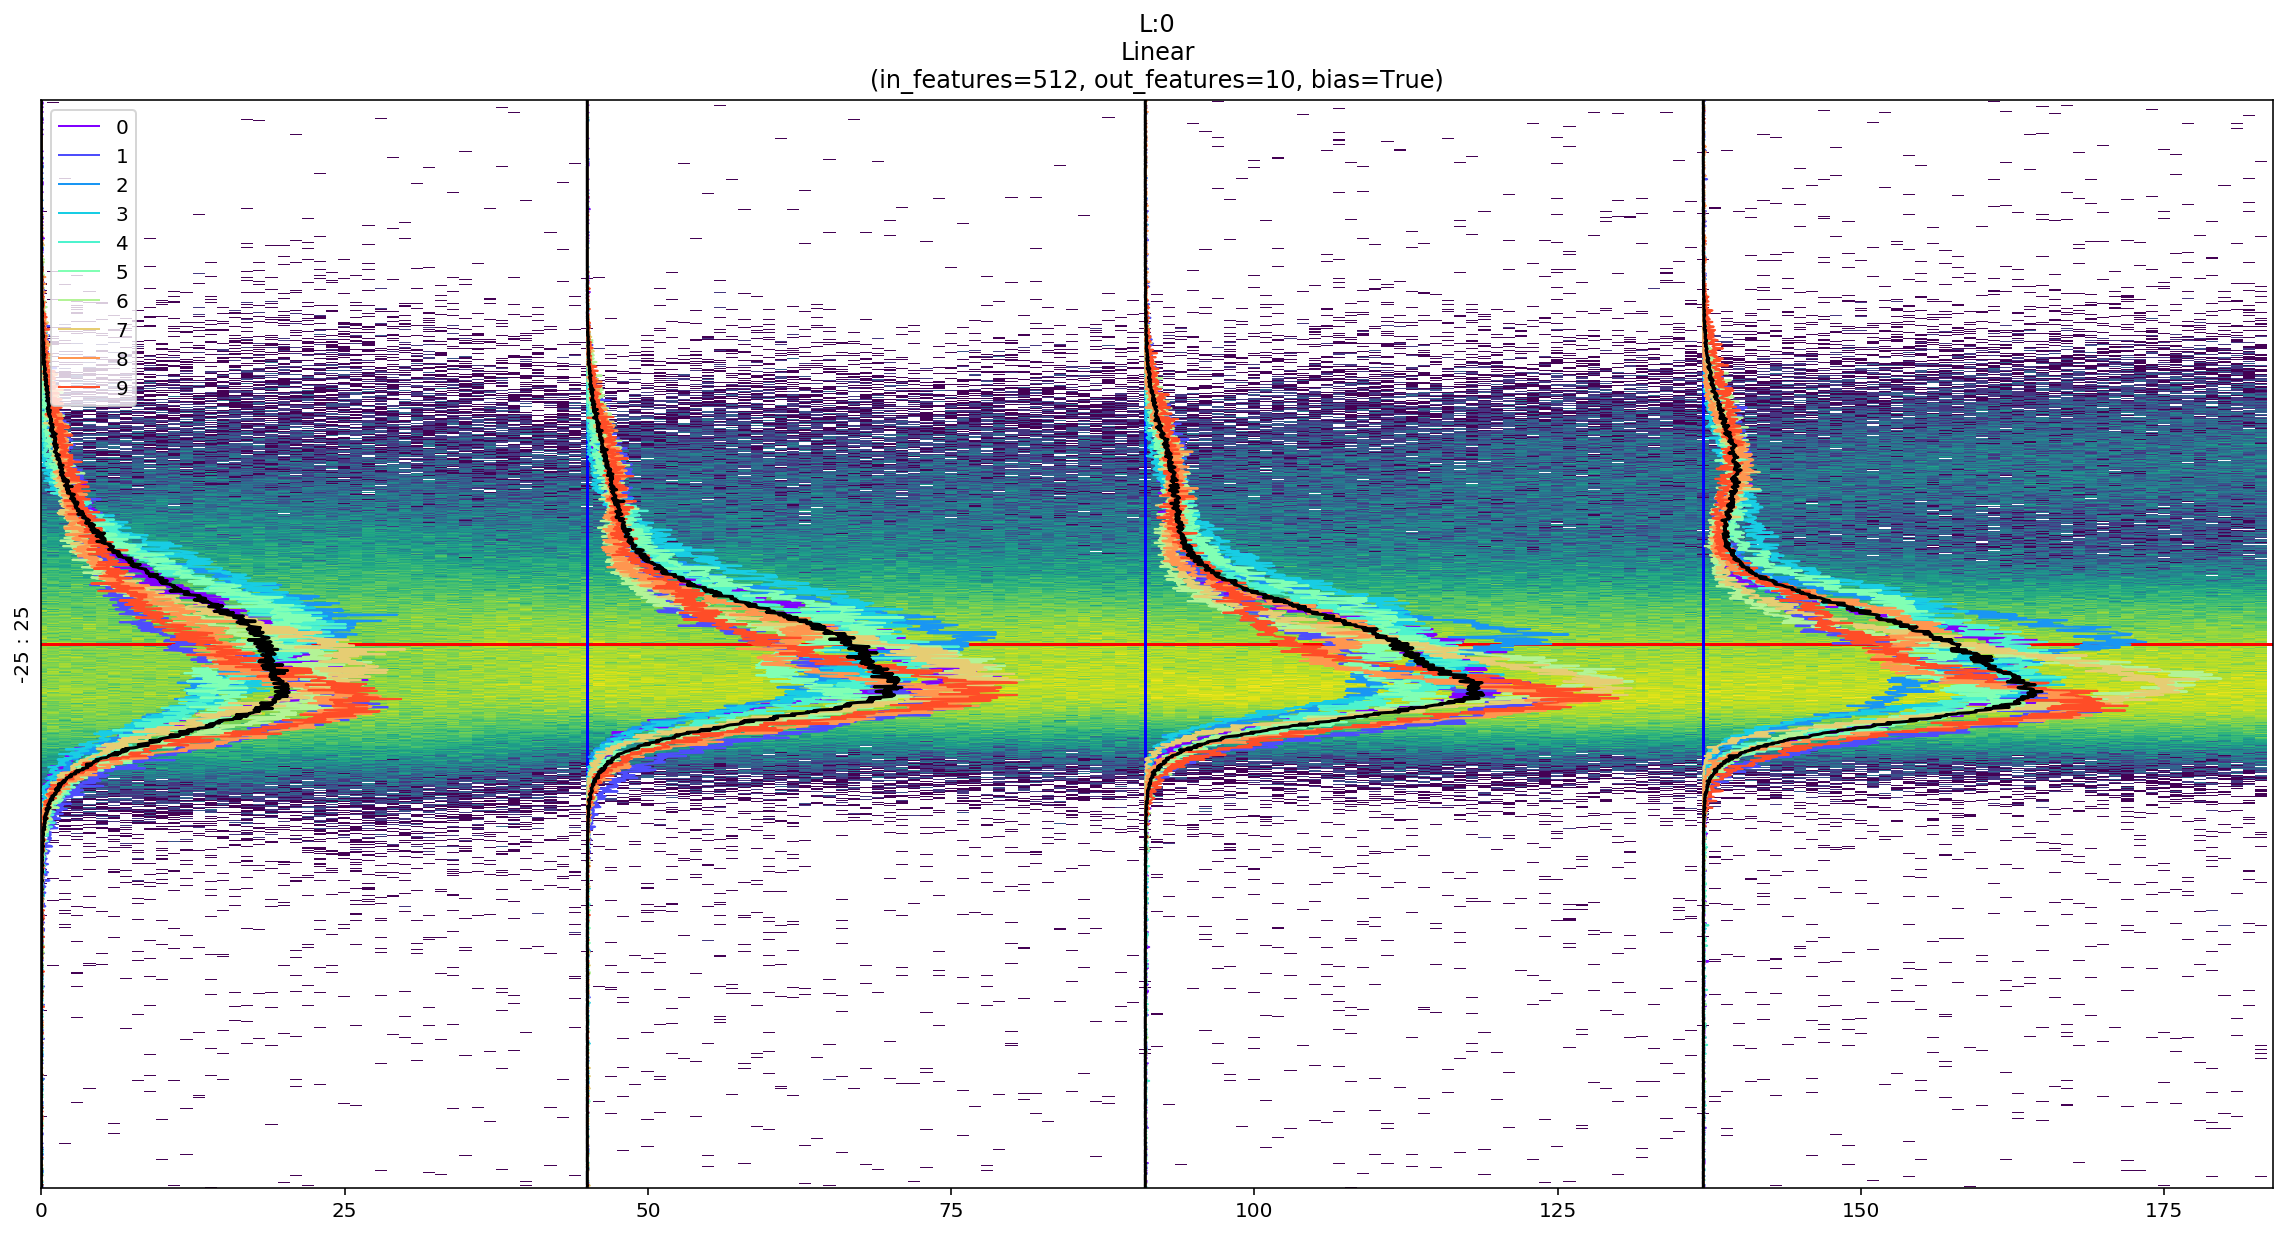

In [21]:
learn.activations_histogram.plotActsHist(cols=1, figsize=(20,10), showEpochs=True, hScale=5, showLayerInfo=True)

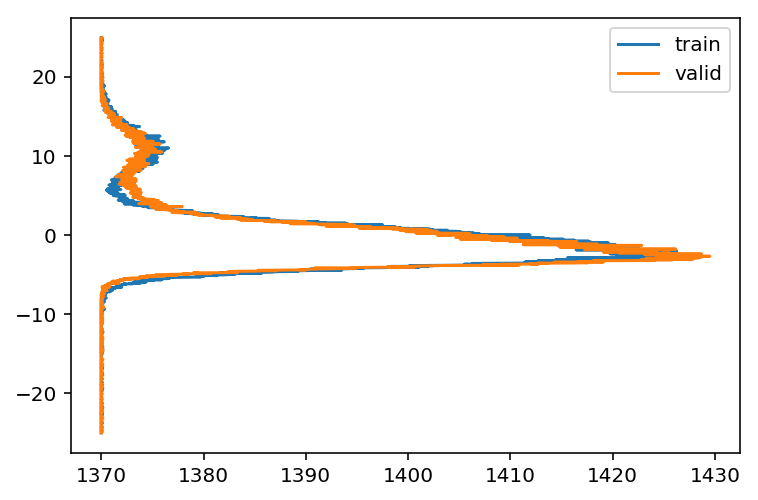

In [22]:
learn.fit_one_cycle(4,max_lr=slice(1e-3))

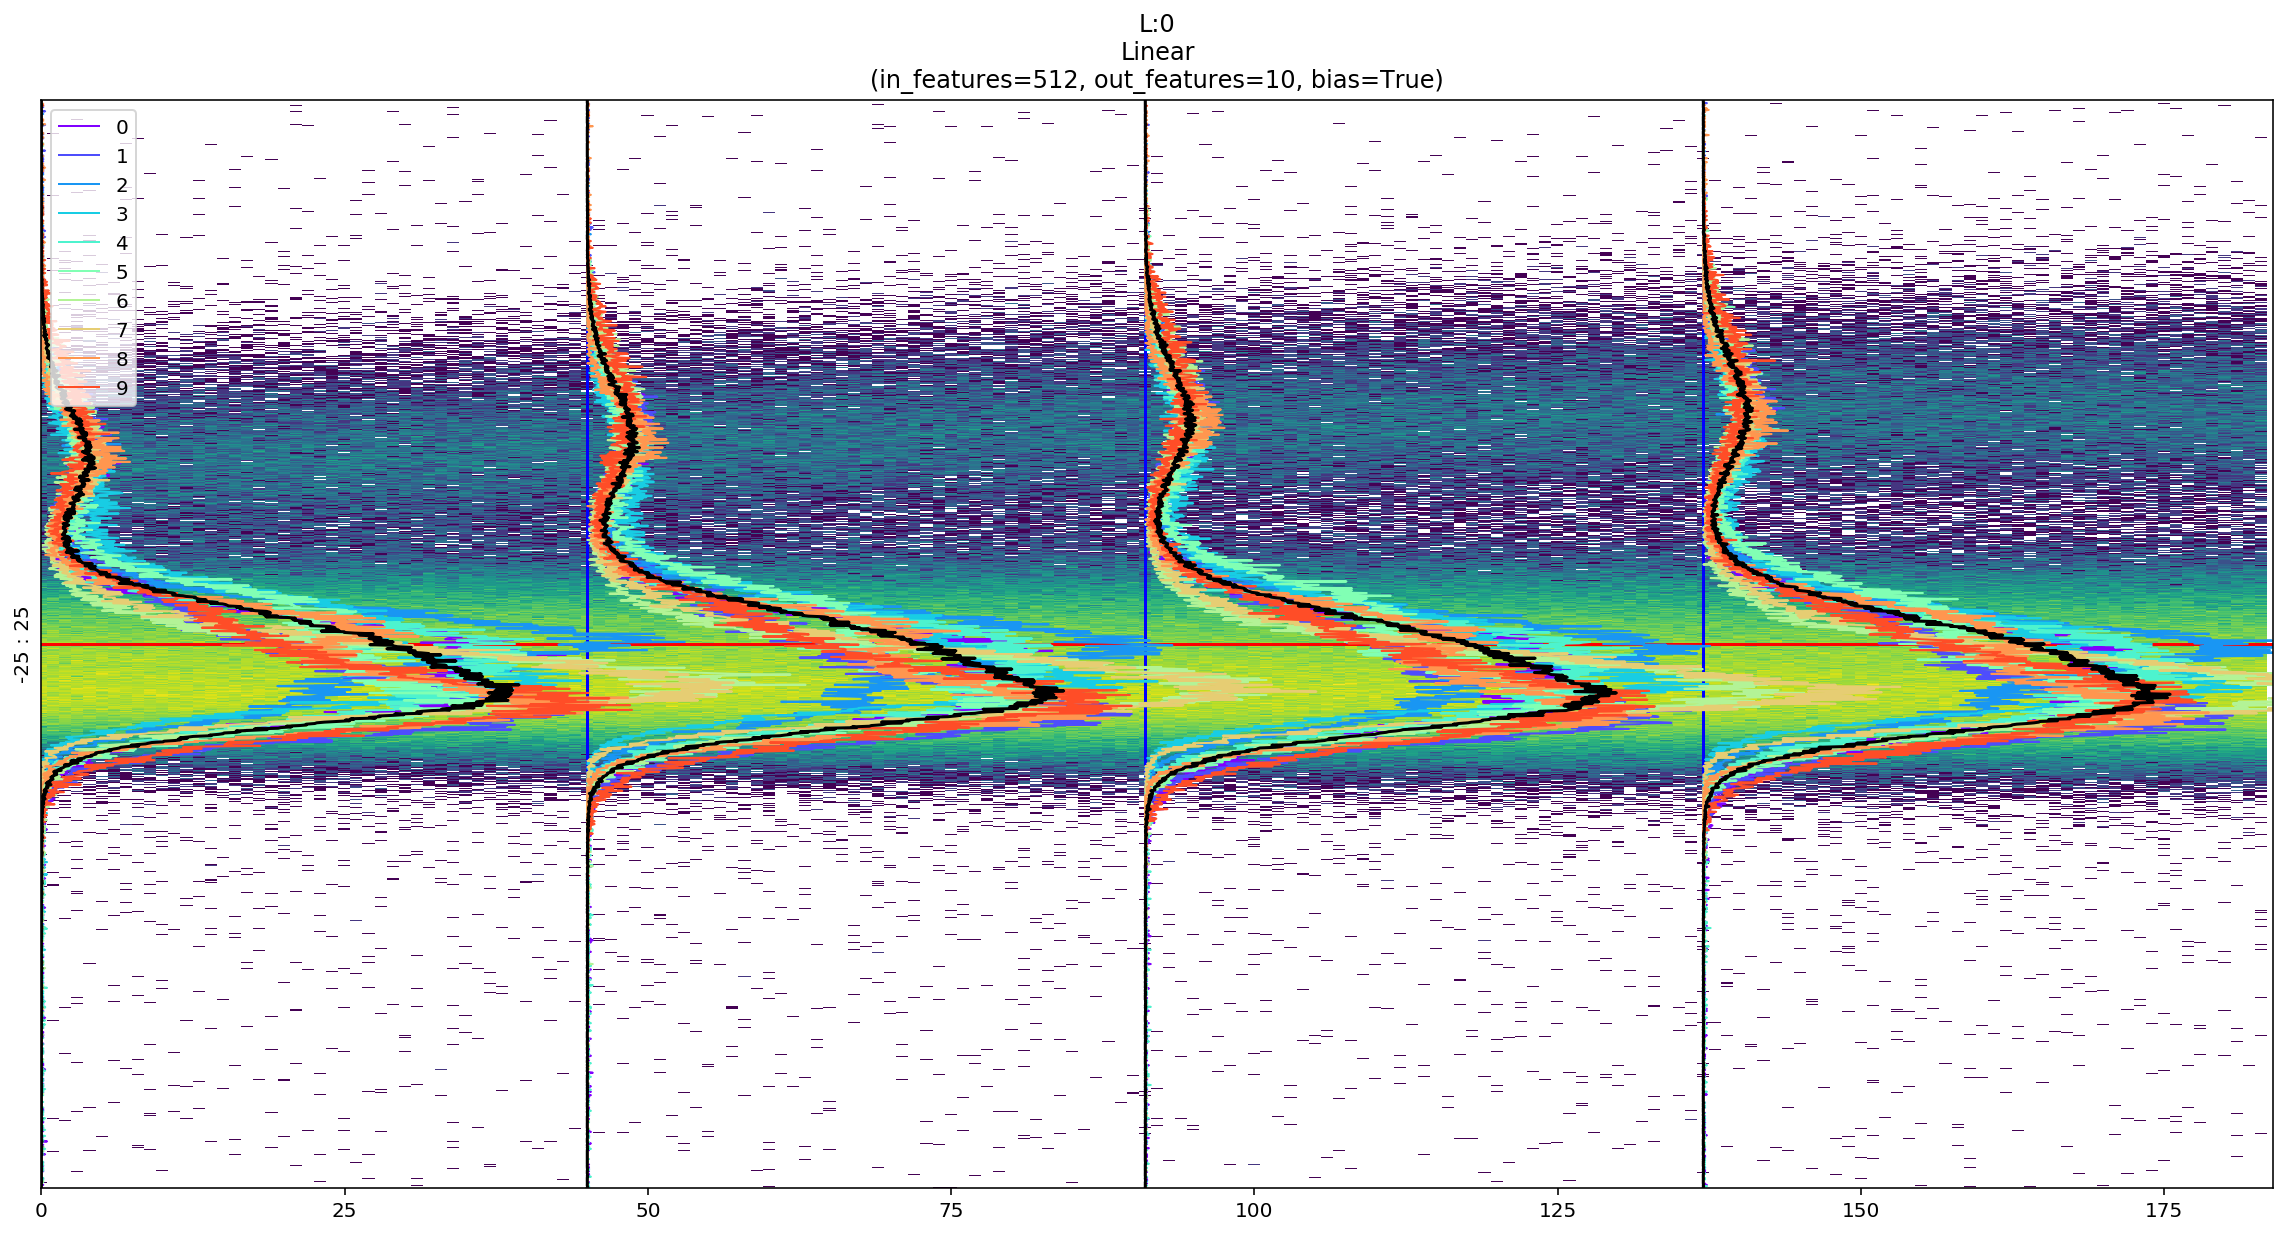

In [23]:
learn.activations_histogram.plotActsHist(cols=1, figsize=(20,10), showEpochs=True, hScale=7, showLayerInfo=True)

From the following sequence of charts we can notice that:
+ The **accuracy increases with the the separation of "peaks"** from .562 in the first epoch of first cycle to .870 of the last epoch in the last cycle where the peaks are well separated.
+ The concept of **'YES'** (small peak on positive Y values) and **'NO'** (big peak in the negative Y) has different heights due to the fact that in a multi class problem the tipical activation is a vector like this `[NO...YES..NO]` with only one YES
+ The height of **NO** peak is `[NUM_CLASSES-1]` times bigger than YES peak.
+ The concept of 'YES' (small peak on positive Y values) and 'NO' (big peak in the negative Y) is slightly different for different classes.